In [ ]:
!pip install tensorflow

In [ ]:
import os, zipfile, random, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from collections import Counter

In [ ]:
import zipfile, shutil, os
from pathlib import Path

# Define paths
DATA_ROOT = Path("./data_extracted_fixed")

train_dir=r"/content/train-20251124T071202Z-1-001.zip"
val_dir=r"/content/valid-20251124T070714Z-1-001.zip"
test_dir=r"/content/test-20251124T071200Z-1-001.zip"
# Clean old extraction if exists
if DATA_ROOT.exists():
    shutil.rmtree(DATA_ROOT)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

def smart_extract(zip_path, target_dir):
    """Extract zip and automatically detect the actual 'train/valid/test' folder level."""
    print(f"Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f"Extracted to {target_dir}")

    # Find the real dataset folder (contains class subfolders)
    # e.g., /data/train/train/...  or /data/train/...
    candidates = list(Path(target_dir).rglob("train"))
    if not candidates:
        candidates = list(Path(target_dir).rglob("Train"))
    if candidates:
        print(f"Found train folder candidate: {candidates[0]}")
    return target_dir

# Extract all datasets
smart_extract(train_dir, DATA_ROOT / "train")
smart_extract(val_dir, DATA_ROOT / "valid")
smart_extract(test_dir,  DATA_ROOT / "test")

# Detect the deepest actual directories that contain class folders
def find_actual_dataset_dir(base_dir):
    base_dir = Path(base_dir)
    subdirs = [p for p in base_dir.rglob("*") if p.is_dir() and any(f.suffix.lower() in ['.jpg', '.jpeg', '.png'] for f in p.glob("*"))]
    if subdirs:
        # Return parent folder containing class folders
        parents = {p.parent for p in subdirs}
        best = min(parents, key=lambda p: len(p.parts))
        print(f"✅ Found valid dataset directory: {best}")
        return best
    else:
        print(f"⚠️ No images found under {base_dir}, check your zip structure.")
        return base_dir

TRAIN_DIR = find_actual_dataset_dir(DATA_ROOT / "train")
VALID_DIR = find_actual_dataset_dir(DATA_ROOT / "valid")
TEST_DIR  = find_actual_dataset_dir(DATA_ROOT / "test")

print(f"\nFinal dataset directories:")
print(f"Train dir: {TRAIN_DIR}")
print(f"Valid dir: {VALID_DIR}")
print(f"Test dir:  {TEST_DIR}")

# Quick verification
for root, dirs, files in os.walk(TRAIN_DIR):
    print(f"\nSample structure check:\n{root} -> {len(dirs)} class folders")
    print("Classes:", dirs)
    break



Extracting /content/train-20251124T071202Z-1-001.zip ...
Extracted to data_extracted_fixed/train
Found train folder candidate: data_extracted_fixed/train/train
Extracting /content/valid-20251124T070714Z-1-001.zip ...
Extracted to data_extracted_fixed/valid
Extracting /content/test-20251124T071200Z-1-001.zip ...
Extracted to data_extracted_fixed/test
✅ Found valid dataset directory: data_extracted_fixed/train/train
✅ Found valid dataset directory: data_extracted_fixed/valid/valid
✅ Found valid dataset directory: data_extracted_fixed/test/test

Final dataset directories:
Train dir: data_extracted_fixed/train/train
Valid dir: data_extracted_fixed/valid/valid
Test dir:  data_extracted_fixed/test/test

Sample structure check:
data_extracted_fixed/train/train -> 4 class folders
Classes: ['meningioma', 'glioma', 'pituitary', 'no_tumor']


In [ ]:

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = Path("data_extracted_fixed")
TRAIN_DIR = DATA_ROOT / "train" / "train"
VALID_DIR = DATA_ROOT / "valid" / "valid"
TEST_DIR  = DATA_ROOT / "test" / "test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
OUTPUT_DIR = Path("models_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)


In [ ]:
def create_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        seed=SEED,
        color_mode="rgb"   # ❠ Force 3-channel RGB to avoid grayscale mismatch
    )
    return ds

train_ds = create_dataset(TRAIN_DIR)
val_ds   = create_dataset(VALID_DIR, shuffle=False)
test_ds  = create_dataset(TEST_DIR, shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


# ❠ Sanity check: verify image shape

# ❠ Sanity check: verify image shape
for images, labels in train_ds.take(1):
    print(f"Sample image batch shape: {images.shape}")
    print(f"Sample label batch shape: {labels.shape}")

# Normalize pixel values to [0–1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Found 246 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Sample image batch shape: (32, 224, 224, 3)
Sample label batch shape: (32,)


In [ ]:
print("✅ Setting up augmentation...")
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1), #height and width shift
    layers.RandomContrast(0.1)
], name="data_augmentation")


✅ Setting up augmentation...


In [ ]:
# ---- Custom CNN ----
def build_custom_cnn(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),# padding same dimensional as input
        layers.BatchNormalization(), # Normalizes the activations of the previous layer, stabilizing and accelerating the training process.
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(), #replacement for flatten()
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

custom_cnn = build_custom_cnn((224,224,3), num_classes)
custom_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
custom_cnn.summary()

# ---- Transfer Learning Models ----
def build_transfer_model(base_model, num_classes=4):
    base_model.trainable = False
    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

transfer_models = {
    "ResNet50": build_transfer_model(applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "MobileNetV2": build_transfer_model(applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "InceptionV3": build_transfer_model(applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
}

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



Training CustomCNN ...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3799 - loss: 1.7413

53/53 ━━━━━━━━━━━━━━━━━━━━ 342s 6s/step - accuracy: 0.3814 - loss: 1.7369 - val_accuracy: 0.3247 - val_loss: 1.3604
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 331s 6s/step - accuracy: 0.5900 - loss: 1.1055 - val_accuracy: 0.3327 - val_loss: 1.3649
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6084 - loss: 1.1523

53/53 ━━━━━━━━━━━━━━━━━━━━ 331s 6s/step - accuracy: 0.6085 - loss: 1.1521 - val_accuracy: 0.3386 - val_loss: 1.3482
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 331s 6s/step - accuracy: 0.6103 - loss: 1.1145 - val_accuracy: 0.3426 - val_loss: 1.3683
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 379s 6s/step - accuracy: 0.6278 - loss: 1.0117 - val_accuracy: 0.3347 - val_loss: 1.5716
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 383s 6s/step - accuracy: 0.6321 - loss: 1.0448 - val_accuracy: 0.3267 - val_loss: 1.6880
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 330s 6s/step - accuracy: 0.6431 - loss: 1.0200 - val_accuracy: 0.4064 - val_loss: 1.3696


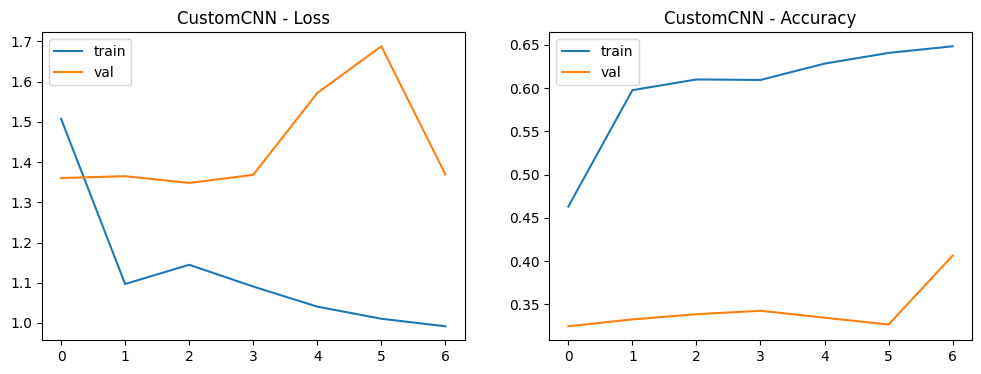

In [ ]:
results = []

def train_model(model, name):
    print(f"\nTraining {name} ...")
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/{name}_best.h5", save_best_only=True)
    ]
    model.compile(optimizer=optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb)
    # Plot history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{name} - Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{name} - Accuracy'); plt.legend()
    plt.show()
    return model, history

# Train Custom CNN
custom_cnn, history_cnn = train_model(custom_cnn, "CustomCNN")




Training ResNet50 ...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2820 - loss: 1.5870

53/53 ━━━━━━━━━━━━━━━━━━━━ 504s 9s/step - accuracy: 0.2817 - loss: 1.5863 - val_accuracy: 0.3227 - val_loss: 1.3560
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2604 - loss: 1.4996

53/53 ━━━━━━━━━━━━━━━━━━━━ 410s 8s/step - accuracy: 0.2606 - loss: 1.4991 - val_accuracy: 0.3367 - val_loss: 1.3407
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2947 - loss: 1.4445

53/53 ━━━━━━━━━━━━━━━━━━━━ 408s 8s/step - accuracy: 0.2946 - loss: 1.4448 - val_accuracy: 0.3486 - val_loss: 1.3300
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3238 - loss: 1.4257

53/53 ━━━━━━━━━━━━━━━━━━━━ 445s 8s/step - accuracy: 0.3236 - loss: 1.4260 - val_accuracy: 0.3645 - val_loss: 1.3158
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3151 - loss: 1.4191

53/53 ━━━━━━━━━━━━━━━━━━━━ 408s 8s/step - accuracy: 0.3149 - loss: 1.4192 - val_accuracy: 0.3984 - val_loss: 1.3077
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3121 - loss: 1.4144

53/53 ━━━━━━━━━━━━━━━━━━━━ 409s 8s/step - accuracy: 0.3121 - loss: 1.4145 - val_accuracy: 0.4004 - val_loss: 1.2964
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3145 - loss: 1.4100

53/53 ━━━━━━━━━━━━━━━━━━━━ 495s 9s/step - accuracy: 0.3146 - loss: 1.4098 - val_accuracy: 0.4143 - val_loss: 1.2878
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3210 - loss: 1.3756

53/53 ━━━━━━━━━━━━━━━━━━━━ 408s 8s/step - accuracy: 0.3211 - loss: 1.3756 - val_accuracy: 0.4143 - val_loss: 1.2776
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3502 - loss: 1.3903

53/53 ━━━━━━━━━━━━━━━━━━━━ 407s 8s/step - accuracy: 0.3501 - loss: 1.3901 - val_accuracy: 0.4343 - val_loss: 1.2708
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3098 - loss: 1.3735

53/53 ━━━━━━━━━━━━━━━━━━━━ 403s 8s/step - accuracy: 0.3101 - loss: 1.3732 - val_accuracy: 0.4263 - val_loss: 1.2610


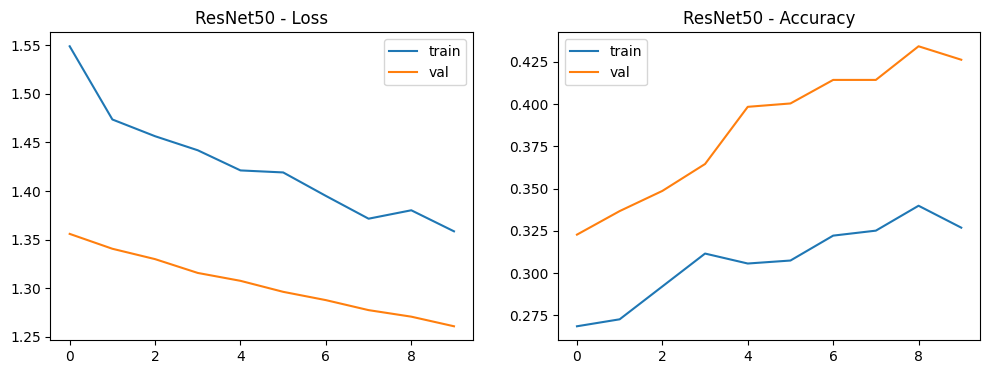


Training MobileNetV2 ...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3137 - loss: 1.6393

53/53 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.3143 - loss: 1.6375 - val_accuracy: 0.4183 - val_loss: 1.2605
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4239 - loss: 1.3324

53/53 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.4245 - loss: 1.3312 - val_accuracy: 0.5000 - val_loss: 1.1176
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5363 - loss: 1.1296

53/53 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.5365 - loss: 1.1294 - val_accuracy: 0.5777 - val_loss: 1.0125
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5575 - loss: 1.0418

53/53 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.5578 - loss: 1.0413 - val_accuracy: 0.6116 - val_loss: 0.9527
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6036 - loss: 0.9632

53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6036 - loss: 0.9630 - val_accuracy: 0.6414 - val_loss: 0.9045
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6288 - loss: 0.8885

53/53 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.6291 - loss: 0.8884 - val_accuracy: 0.6554 - val_loss: 0.8611
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6540 - loss: 0.8459

53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6543 - loss: 0.8456 - val_accuracy: 0.6713 - val_loss: 0.8228
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6438 - loss: 0.8471

53/53 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.6442 - loss: 0.8464 - val_accuracy: 0.6833 - val_loss: 0.8077
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7109 - loss: 0.7557

53/53 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7108 - loss: 0.7559 - val_accuracy: 0.6932 - val_loss: 0.7841
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7136 - loss: 0.7282

53/53 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.7135 - loss: 0.7281 - val_accuracy: 0.6892 - val_loss: 0.7670


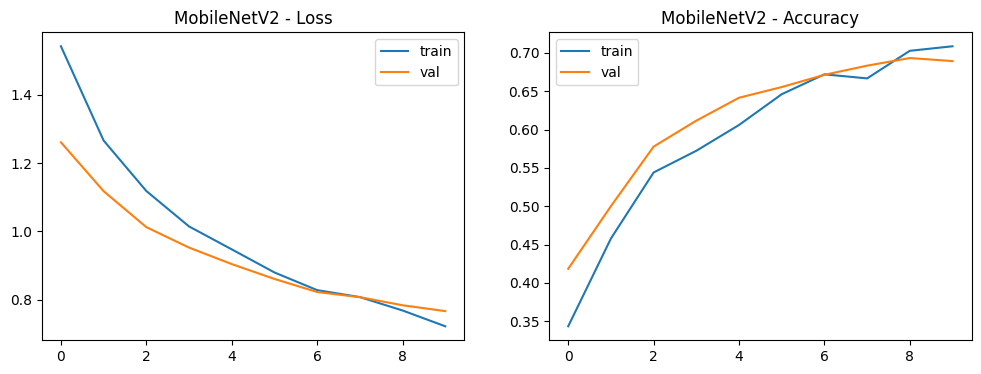


Training InceptionV3 ...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3016 - loss: 1.5095

53/53 ━━━━━━━━━━━━━━━━━━━━ 300s 5s/step - accuracy: 0.3027 - loss: 1.5080 - val_accuracy: 0.5120 - val_loss: 1.1740
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4696 - loss: 1.2520

53/53 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - accuracy: 0.4699 - loss: 1.2513 - val_accuracy: 0.5777 - val_loss: 1.0443
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5438 - loss: 1.1151

53/53 ━━━━━━━━━━━━━━━━━━━━ 287s 5s/step - accuracy: 0.5441 - loss: 1.1144 - val_accuracy: 0.5916 - val_loss: 0.9840
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6267 - loss: 0.9731

53/53 ━━━━━━━━━━━━━━━━━━━━ 322s 5s/step - accuracy: 0.6268 - loss: 0.9730 - val_accuracy: 0.6375 - val_loss: 0.8905
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6565 - loss: 0.8926

53/53 ━━━━━━━━━━━━━━━━━━━━ 289s 5s/step - accuracy: 0.6563 - loss: 0.8929 - val_accuracy: 0.6633 - val_loss: 0.8392
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.6503 - loss: 0.8689 - val_accuracy: 0.6514 - val_loss: 0.8403
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6725 - loss: 0.8223

53/53 ━━━━━━━━━━━━━━━━━━━━ 288s 5s/step - accuracy: 0.6727 - loss: 0.8220 - val_accuracy: 0.6633 - val_loss: 0.8292
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6830 - loss: 0.8085

53/53 ━━━━━━━━━━━━━━━━━━━━ 344s 6s/step - accuracy: 0.6832 - loss: 0.8081 - val_accuracy: 0.6713 - val_loss: 0.7792
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6979 - loss: 0.7791

53/53 ━━━━━━━━━━━━━━━━━━━━ 299s 5s/step - accuracy: 0.6981 - loss: 0.7790 - val_accuracy: 0.7072 - val_loss: 0.7433
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 322s 5s/step - accuracy: 0.6963 - loss: 0.7624 - val_accuracy: 0.7012 - val_loss: 0.7443


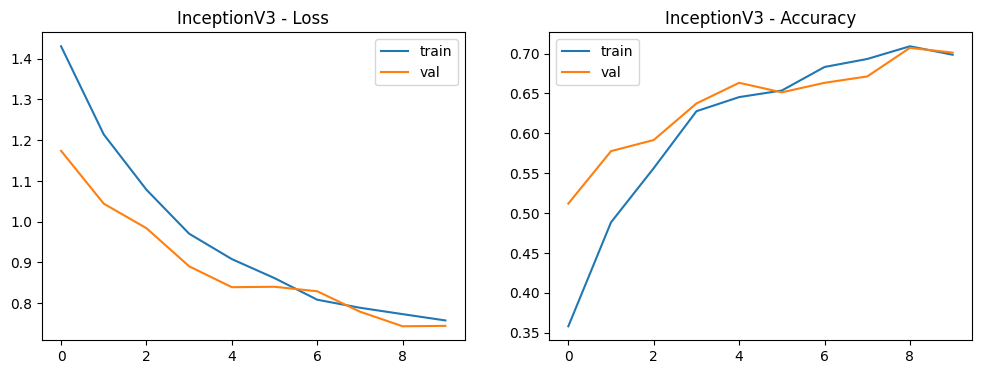

In [10]:
# Train Transfer Models
for name, model in transfer_models.items():
    model, hist = train_model(model, name)
    transfer_models[name] = model

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


📊 CustomCNN Results:
Accuracy=0.3618  Precision=0.2069  Recall=0.3618  F1=0.2252
              precision    recall  f1-score   support

      glioma       0.36      1.00      0.53        80
  meningioma       0.35      0.14      0.20        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.36       246
   macro avg       0.18      0.29      0.18       246
weighted avg       0.21      0.36      0.23       246



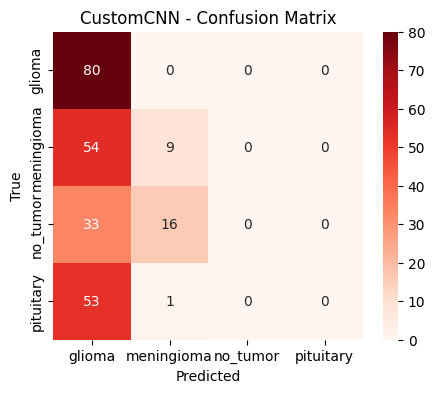


📊 ResNet50 Results:
Accuracy=0.4228  Precision=0.2676  Recall=0.4228  F1=0.2948
              precision    recall  f1-score   support

      glioma       0.38      1.00      0.55        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.73      0.49      0.59        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.42       246
   macro avg       0.28      0.37      0.28       246
weighted avg       0.27      0.42      0.29       246



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

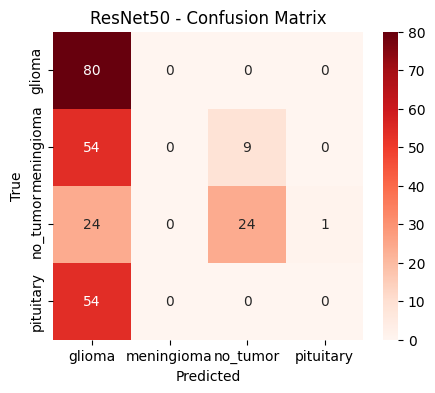


📊 MobileNetV2 Results:
Accuracy=0.7195  Precision=0.7639  Recall=0.7195  F1=0.7114
              precision    recall  f1-score   support

      glioma       0.84      0.78      0.81        80
  meningioma       0.84      0.43      0.57        63
    no_tumor       0.76      0.71      0.74        49
   pituitary       0.56      0.98      0.72        54

    accuracy                           0.72       246
   macro avg       0.75      0.72      0.71       246
weighted avg       0.76      0.72      0.71       246



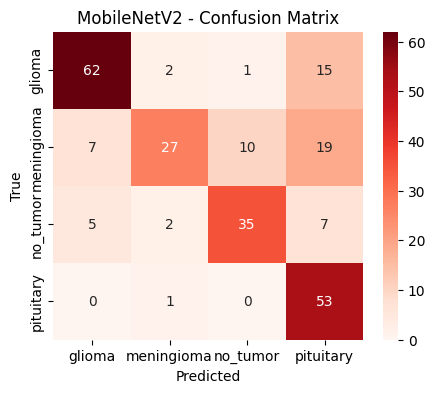


📊 InceptionV3 Results:
Accuracy=0.6626  Precision=0.6926  Recall=0.6626  F1=0.6442
              precision    recall  f1-score   support

      glioma       0.80      0.74      0.77        80
  meningioma       0.67      0.29      0.40        63
    no_tumor       0.74      0.71      0.73        49
   pituitary       0.52      0.94      0.67        54

    accuracy                           0.66       246
   macro avg       0.68      0.67      0.64       246
weighted avg       0.69      0.66      0.64       246



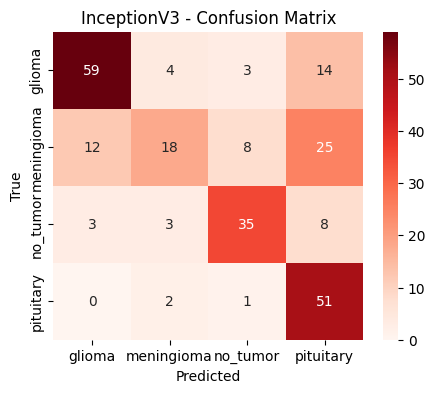

In [11]:
def evaluate_model(model, name):
    y_true, y_pred = [], []
    for imgs, labels in test_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"\n📊 {name} Results:")
    print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# Evaluate all models
results.append(evaluate_model(custom_cnn, "CustomCNN"))
for name, model in transfer_models.items():
    results.append(evaluate_model(model, name))




✅ Model Comparison Summary:
         model  accuracy  precision    recall        f1
2  MobileNetV2  0.719512   0.763873  0.719512  0.711411
3  InceptionV3  0.662602   0.692582  0.662602  0.644165
1     ResNet50  0.422764   0.267581  0.422764  0.294791
0    CustomCNN  0.361789   0.206905  0.361789  0.225237


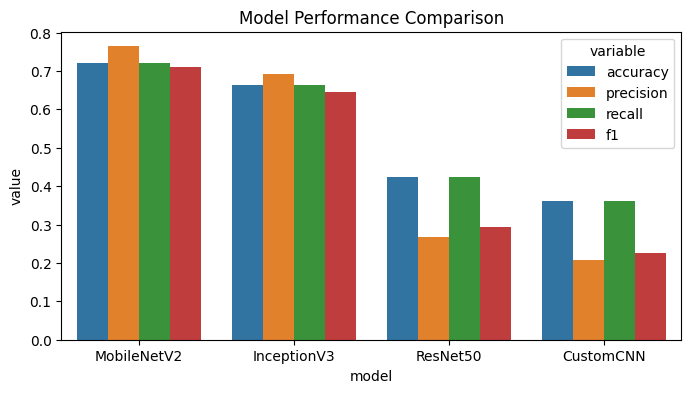


🏆 Best Performing Model: MobileNetV2


In [12]:

df = pd.DataFrame(results).sort_values("f1", ascending=False)
print("\n✅ Model Comparison Summary:")
print(df)

plt.figure(figsize=(8,4))
sns.barplot(data=df.melt(id_vars='model', value_vars=['accuracy','precision','recall','f1']),
            x='model', y='value', hue='variable')
plt.title("Model Performance Comparison")
plt.show()

best_model_name = df.iloc[0]["model"]
print(f"\n🏆 Best Performing Model: {best_model_name}")

In [13]:

import pickle
from tensorflow.keras.models import load_model

# save to h5
best_model_path = f"models_outputs/{best_model_name}_best.h5"
best_model = load_model(best_model_path)

# Save to pickle
pickle_path = f"models_outputs/{best_model_name}_best.pkl"
with open(pickle_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Saved best model as: {pickle_path}")


✅ Saved best model as: models_outputs/MobileNetV2_best.pkl
